In [40]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax

In [56]:
@jnp.vectorize
def b_spline(x,k,d):
    if d == 0:
        if (k <= x) * (x < (k + 1)):
            return 1.0
        else:
            return 0.0
    
    return ((x - k)/(d) * b_spline(x,k,d-1)) + ((k + d + 1 - x)/(d + 1) * b_spline(x,k+1,d-1))

vb_spline = jax.vmap(b_spline)

In [57]:
x_grid = np.linspace(-3,3,5)
y_grid = 1 - np.exp(-(x_grid)**2)

In [58]:
class DeboorInterp:
    def __init__(self,x_grid,n):
        self.dx = x_grid[1] - x_grid[0]
        self.x_grid = x_grid
        self.n = n
        self.k = jnp.arange(0,len(x_grid),dtype=int)
        
    def __call__(self,p,x,*args):
        temp = (x[None,:] - np.min(self.x_grid[None,:]))/self.dx
        print(temp.shape)
        temp = b_spline(temp,self.k[:,None],self.n)
        print(temp.shape)
        
        return jnp.dot(p, temp)

In [59]:
interpolater = DeboorInterp(x_grid,3)

In [60]:
xs = np.linspace(-3,3)
ys = interpolater(y_grid,xs)

(1, 50)


ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(bool[50])>with<BatchTrace(level=1/0)> with
    val = Array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False, False, False, False, False, False, False, False,
        False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True]], dtype=bool)
    batch_dim = 0
  batch_dim = 0
The problem arose with the `bool` function. 
This BatchTracer with object id 22912376531568 was created on line:
  /state/partition1/job-35670624/ipykernel_1343030/51092163.py:4:11 (b_spline)

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [29]:
ys.shape

(50,)

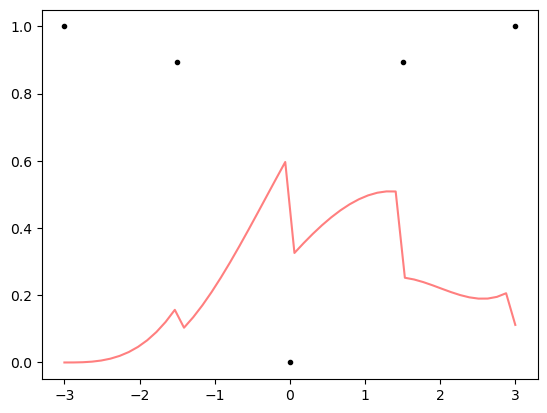

In [30]:
plt.plot(x_grid,y_grid,'.k')
plt.plot(xs,ys,'-r',alpha=0.5)
plt.show()

In [61]:
import sys
sys.path.insert(0,'..')
import jabble.model

In [66]:
jabble.model.BSpline(p=0).alphas

Array([[1.]], dtype=float32)

In [64]:
jabble.model.BSpline(p=1).alphas

Array([[ 0.,  1.],
       [ 1., -1.]], dtype=float32)

In [65]:
jabble.model.BSpline(p=2).alphas

Array([[ 0. ,  0.5,  0.5],
       [ 0. ,  1. , -1. ],
       [ 0.5, -1. ,  0.5]], dtype=float32)